In [1]:
# !pip  install opendatasets transformers --quiet

In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arhamrafique
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 641MB/s]

In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device  = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device using is {device}')

Device using is cuda


In [7]:
df = pd.read_json('/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)

In [8]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [9]:
df.shape

(26709, 3)

In [10]:
df.isnull().sum()

,0
article_link,0
headline,0
is_sarcastic,0


In [11]:
df.duplicated().sum()

np.int64(1)

In [12]:
df.dropna(inplace=True)

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.shape

(26708, 3)

In [16]:
df.drop('article_link', inplace=True, axis=1)

In [17]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["headline"]), np.array(df["is_sarcastic"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [25]:
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/df.shape[0],4)*100, "%")
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/df.shape[0],4)*100, "%")
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/df.shape[0],4)*100, "%")

Training set is:  18695  rows which is  70.0 %
Validation set is:  4006  rows which is  15.0 %
Testing set is:  4007  rows which is  15.0 %


In [26]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [27]:
class dataset(Dataset):
  def __init__(self, X, y):
        self.X = [tokenizer(x, max_length = 100, truncation = True, padding = 'max_length', return_tensors='pt').to(device) for x in X]
        self.y = torch.tensor(y , dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]


In [28]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [29]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

In [30]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [31]:
class MyModel(nn.Module):
    def __init__(self, bert):

        super(MyModel, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask, return_dict = False)[0][:,0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output

In [33]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

In [34]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

In [35]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for indx, data in enumerate(train_dataloader):
        input, label = data

        input.to(device)
        label.to(device)

        prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)


        batch_loss = criterion(prediction, label)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == label).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for indx, data in enumerate(validation_dataloader):
            input, label = data
            input.to(device)
            label.to(device)

            prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)

            batch_loss_val = criterion(prediction, label)
            total_loss_val += batch_loss_val.item()


            acc = ((prediction).round() == label).sum().item()

            total_acc_val += acc


    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/100, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/100:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("-"*50)


Epoch no. 1 Train Loss: 0.2625 Train Accuracy: 80.0428 Validation Loss: 0.4800 Validation Accuracy: 83.8742
--------------------------------------------------
Epoch no. 2 Train Loss: 0.2124 Train Accuracy: 84.4076 Validation Loss: 0.4340 Validation Accuracy: 85.8213
--------------------------------------------------
Epoch no. 3 Train Loss: 0.1998 Train Accuracy: 85.1137 Validation Loss: 0.4176 Validation Accuracy: 86.2706
--------------------------------------------------
Epoch no. 4 Train Loss: 0.1917 Train Accuracy: 85.7074 Validation Loss: 0.4206 Validation Accuracy: 85.7464
--------------------------------------------------
Epoch no. 5 Train Loss: 0.1885 Train Accuracy: 86.0444 Validation Loss: 0.4167 Validation Accuracy: 86.1208
--------------------------------------------------
Epoch no. 6 Train Loss: 0.1841 Train Accuracy: 86.1728 Validation Loss: 0.4012 Validation Accuracy: 86.7199
--------------------------------------------------
Epoch no. 7 Train Loss: 0.1821 Train Accuracy:

In [36]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, data in enumerate(testing_dataloader):
    input, label = data
    input.to(device)
    label.to(device)

    prediction = model(input['input_ids'].squeeze(1), input['attention_mask'].squeeze(1)).squeeze(1)

    batch_loss_val = criterion(prediction, label)
    total_loss_test += batch_loss_val.item()
    acc = ((prediction).round() == label).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 85.4%


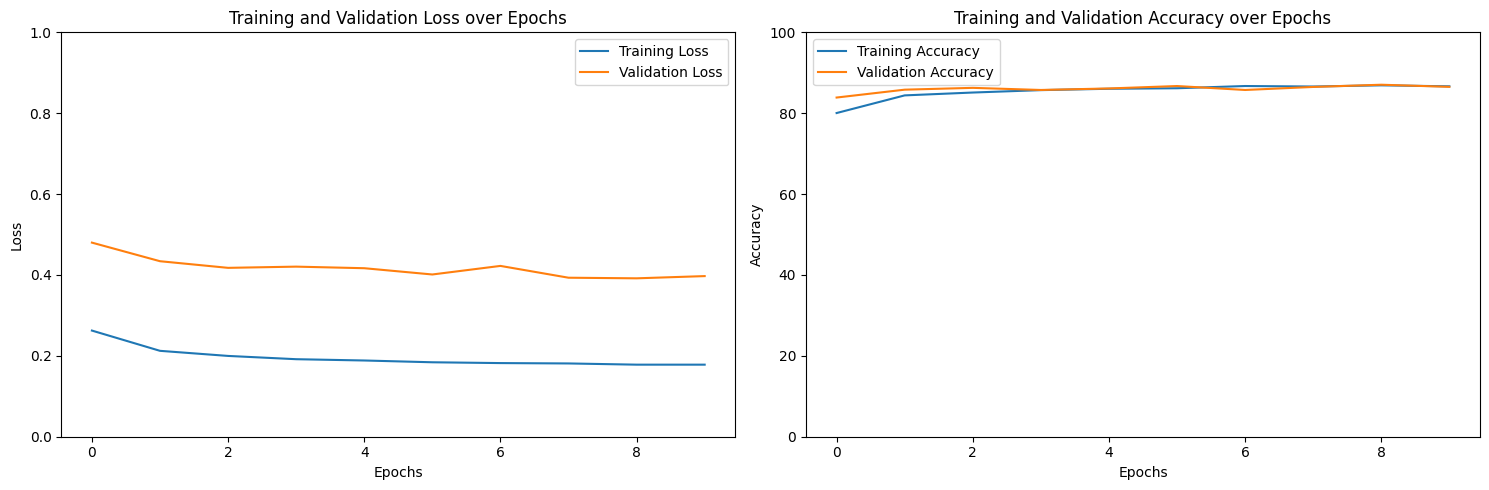

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()